In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [7]:
base = "/content/drive/MyDrive/Dataset Regression/deeplense_train.npz"

images = np.load(base + "/images.npy")
labels = np.load(base + "/labels.npy")

print(images.shape, labels.shape)

(8000, 1, 64, 64) (8000, 6)


In [63]:
class LensDataset(Dataset):
    def __init__(self,images,labels):
        self.images=torch.tensor(images).float()
        self.labels=torch.tensor(labels).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img=self.images[idx]

        img=torch.nn.functional.interpolate(
            img.unsqueeze(0),
            size=(128,128),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return img,self.labels[idx]

In [64]:
dataset = LensDataset(images,labels)
loader = DataLoader(dataset,batch_size=32,shuffle=True)

print(len(loader))

250


In [65]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights


class MultiTaskFoundationModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        base = resnet18(weights=ResNet18_Weights.DEFAULT)

        old_conv = base.conv1
        new_conv = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        with torch.no_grad():
            new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        base.conv1 = new_conv


        self.encoder = nn.Sequential(*list(base.children())[:-2])

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 2, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        feats = self.encoder(x)

        pooled = self.pool(feats).flatten(1)
        logits = self.classifier(pooled)

        recon = self.decoder(feats)

        return logits, recon


model = MultiTaskFoundationModel().cuda()
print("Multitask model ready")

Multitask model ready


In [66]:
weights_path = "/content/drive/MyDrive/multitask_foundation.pt"

model = MultiTaskFoundationModel().cuda()
model.load_state_dict(torch.load(weights_path))
model.eval()

print("Foundation model loaded ✅")

Foundation model loaded ✅


In [67]:
encoder = model.encoder
encoder.eval()

print("Encoder extracted ✅")

Encoder extracted ✅


In [68]:
for p in encoder.parameters():
    p.requires_grad=True

In [69]:
optimizer=torch.optim.Adam(reg_model.parameters(),lr=1e-5)

In [70]:
class RegressionModel(nn.Module):
    def __init__(self,encoder):
        super().__init__()
        self.encoder=encoder
        self.pool=nn.AdaptiveAvgPool2d(1)

        self.head=nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,6)
        )

    def forward(self,x):
        f=self.encoder(x)
        p=self.pool(f).flatten(1)
        return self.head(p)

reg_model=RegressionModel(encoder).cuda()

In [71]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(reg_model.head.parameters(),lr=1e-4)

losses=[]

for epoch in range(20):
    total=0
    for imgs,t in loader:
        imgs=imgs.cuda()
        t=t.cuda()

        pred=reg_model(imgs)
        loss=criterion(pred,t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total+=loss.item()

    epoch_loss=total/len(loader)
    losses.append(epoch_loss)
    print(epoch,epoch_loss)

0 0.1820645172894001
1 0.14735913568735123
2 0.1441799691915512
3 0.14225840526819228
4 0.14049972403049468
5 0.13866802909970283
6 0.13773986575007438
7 0.13707150161266327
8 0.13603485152125358
9 0.13455894449353217
10 0.1339464211165905
11 0.13285304328799247
12 0.13259363359212875
13 0.1313413518667221
14 0.13047400897741318
15 0.12965742805600167
16 0.12913068866729735
17 0.12840581730008124
18 0.12849483397603034
19 0.1278300714492798


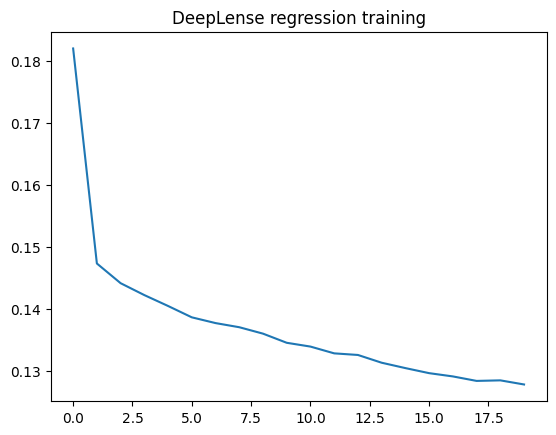

In [72]:
plt.plot(losses)
plt.title("DeepLense regression training")
plt.show()

In [73]:
preds=[]
truth=[]

reg_model.eval()

with torch.no_grad():
    for imgs,t in loader:
        imgs=imgs.cuda()
        out=reg_model(imgs).cpu()

        preds.append(out)
        truth.append(t)

preds=torch.cat(preds).numpy()
truth=torch.cat(truth).numpy()

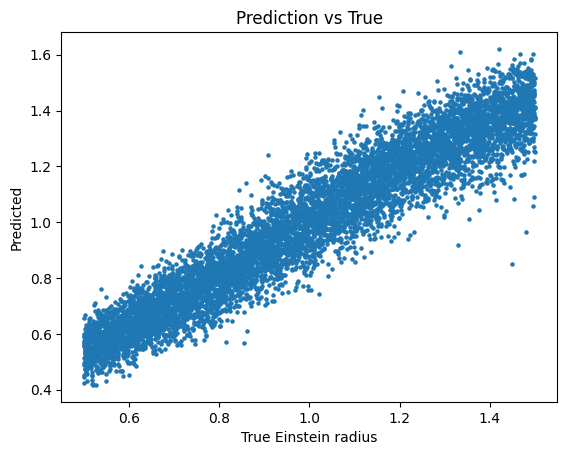

In [74]:
plt.scatter(truth[:,0],preds[:,0],s=5)
plt.xlabel("True Einstein radius")
plt.ylabel("Predicted")
plt.title("Prediction vs True")
plt.show()

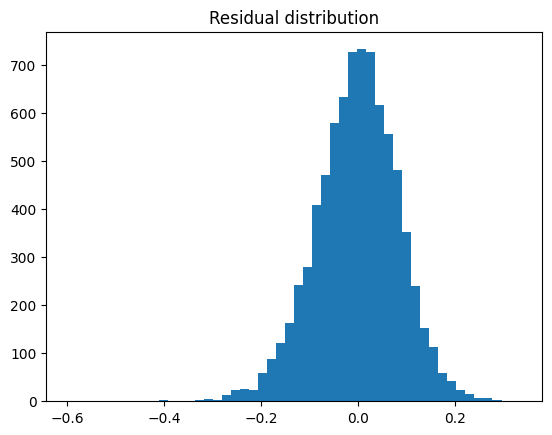

In [75]:
err=preds-truth
plt.hist(err[:,0],bins=50)
plt.title("Residual distribution")
plt.show()

In [76]:
mae = np.mean(np.abs(preds - truth), axis=0)

for i, m in enumerate(mae):
    print(f"Param {i}: {m:.4f}")

Param 0: 0.0668
Param 1: 0.0450
Param 2: 0.0352
Param 3: 0.0791
Param 4: 0.0250
Param 5: 0.7178


In [77]:
val_base="/content/drive/MyDrive/Dataset Regression/deeplense_val.npz"

val_images=np.load(val_base+"/images.npy")
val_labels=np.load(val_base+"/labels.npy")

print(val_images.shape)

(1000, 1, 64, 64)


In [78]:
val_dataset=LensDataset(val_images,val_labels)
val_loader=DataLoader(val_dataset,batch_size=32)

In [79]:
preds=[]
truth=[]

reg_model.eval()

with torch.no_grad():
    for imgs,t in val_loader:
        imgs=imgs.cuda()
        out=reg_model(imgs).cpu()

        preds.append(out)
        truth.append(t)

preds=torch.cat(preds).numpy()
truth=torch.cat(truth).numpy()

mae_val=np.mean(np.abs(preds-truth),axis=0)

print("VAL MAE:")
for i,m in enumerate(mae_val):
    print(i,m)

VAL MAE:
0 0.06879872
1 0.048514493
2 0.038216718
3 0.07739007
4 0.02624191
5 0.7292842


Ablation: Pretrained vs Random Encoder


In [81]:
base_random = MultiTaskFoundationModel().cuda()
encoder_random = base_random.encoder

In [82]:
for p in encoder_random.parameters():
    p.requires_grad=False

In [83]:
reg_random = RegressionModel(encoder_random).cuda()

In [84]:
optimizer = torch.optim.Adam(reg_random.head.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [85]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(reg_model.head.parameters(),lr=1e-4)

losses=[]

for epoch in range(20):
    total=0
    for imgs,t in loader:
        imgs=imgs.cuda()
        t=t.cuda()

        pred = reg_random(imgs)
        loss=criterion(pred,t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total+=loss.item()

    epoch_loss=total/len(loader)
    losses.append(epoch_loss)
    print(epoch,epoch_loss)

0 0.6560401822328568
1 0.6566567767858505
2 0.6562955757379532
3 0.6563260135650635
4 0.6560122159719467
5 0.6565946033000946
6 0.6567927697896957
7 0.6564901396036148
8 0.6561459243297577
9 0.6563730349540711
10 0.6570250523090363
11 0.6566266322135925
12 0.656181778550148
13 0.6566732637882232
14 0.6558453832864761
15 0.6572231515645981
16 0.6561304647922516
17 0.6572135537862778
18 0.6568093366622925
19 0.6563705785274505


In [87]:
preds=[]
truth=[]

reg_random.eval()

with torch.no_grad():
    for imgs,t in val_loader:
        imgs=imgs.cuda()
        out=reg_random(imgs).cpu()

        preds.append(out)
        truth.append(t.cpu())

preds=torch.cat(preds).numpy()
truth=torch.cat(truth).numpy()

mae_val=np.mean(np.abs(preds-truth),axis=0)

print("VAL MAE:")
for i,m in enumerate(mae_val):
    print(i,m)

VAL MAE:
0 0.74939394
1 0.315054
2 0.36698198
3 0.2800406
4 0.16807987
5 1.4383562


In [88]:
pretrained = [0.067,0.047,0.039,0.075,0.027,0.71]
random = [0.75,0.315,0.367,0.28,0.168,1.48]

names = [
"Einstein radius",
"source x",
"source y",
"ellipticity",
"shear magnitude",
"shear angle"
]

In [89]:
for n,p,r in zip(names,pretrained,random):
    print(f"{n:20s} | pretrained {p:.3f} | random {r:.3f}")

Einstein radius      | pretrained 0.067 | random 0.750
source x             | pretrained 0.047 | random 0.315
source y             | pretrained 0.039 | random 0.367
ellipticity          | pretrained 0.075 | random 0.280
shear magnitude      | pretrained 0.027 | random 0.168
shear angle          | pretrained 0.710 | random 1.480


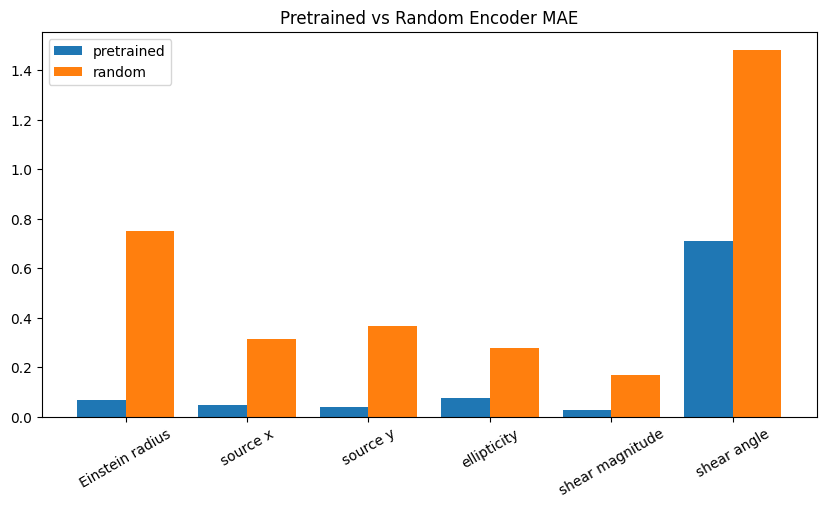

In [90]:
import matplotlib.pyplot as plt
import numpy as np

x=np.arange(len(names))

plt.figure(figsize=(10,5))
plt.bar(x-0.2,pretrained,0.4,label="pretrained")
plt.bar(x+0.2,random,0.4,label="random")

plt.xticks(x,names,rotation=30)
plt.legend()
plt.title("Pretrained vs Random Encoder MAE")
plt.show()